In [1]:
from qTools import *
import Cahit as ck

import scipy.sparse as sp
import numpy as np

from functools import partial
from multiprocessing import Pool, cpu_count

import matplotlib.pyplot as plt

### Define parameters

In [2]:
resonatorDimension = 200
g = 1.79
qfreq = 0
resFreq = 2
irreg = False

### Define your digital algorithm

This is going to be improved

In [3]:
def digitalRabi(obj, stepSize):
    sigmaX = sp.kron(QuantumToolbox.operators.identity(obj.subSystems['Cavity1'].dimension), obj.sigmaX(obj.subSystems['Qubit1'].dimension), format='csc')
    HamJC = 2 * np.pi * (((obj.subSystems['Cavity1'].frequency/2)*obj.subSystems['Cavity1'].freeMat) + obj.couplingHam)
    UnitaryJC = QuantumToolbox.liouvillian.Liouvillian(HamJC, timeStep=(stepSize / 2))
    UnitaryAJC = (UnitaryJC @ UnitaryJC)
    Unitary = UnitaryJC @ sigmaX @ UnitaryAJC @ sigmaX @ UnitaryJC
    return Unitary

### Create Simulation

Then get reference to quantum system attachted to it.
or, you can also create your quantum system then attach.

In [4]:
qSim = Simulation()
JCSys = qSim.qSys

### Create sub-Systems

In [5]:
cav = Cavity(dimension=resonatorDimension, frequency=resFreq)
JCSys.addSubSys(cav)

qub = JCSys.createSubSys(subClass=Qubit)
qub.frequency = qfreq

Qubit requires a frequency


### Create a JC coupling

This is the only available standard coupling
Below code shows how the they are going to work

In [6]:
JCcoupling = JCSys.JC(cav, qub, g)

sigmaz


### Define Simulation and System conditions

Initial state, cavity frequency sweep, and simultion time

In [7]:
JCSys.initialState = [0,0]

cavFreqSweep = qSim.Loop.addSweep(sys=cav, sweepKey='frequency')
cavFreqSweep.sweepList = np.arange(-4, 4+0.05, 0.05)

"""gSweep = qSim.beforeLoop.addSweep(sys=JCcoupling, sweepKey='couplingStrength')
gSweep.sweepList = np.arange(0, 2, 0.05)"""

qSim.steps = 60

### Create a Pool and run the simulation

In [8]:
JCSys.constructCompSys()
cavParity = parityEXP(cav.freeMat)
def expect(qSys, state):
    expect = expectationKet(cavParity, state)
    return expect

qSim.compute = expect

In [9]:
p = Pool(processes=cpu_count())
print('simulating')
statesDigit, parityDigit = qSim.run(p)

simulating


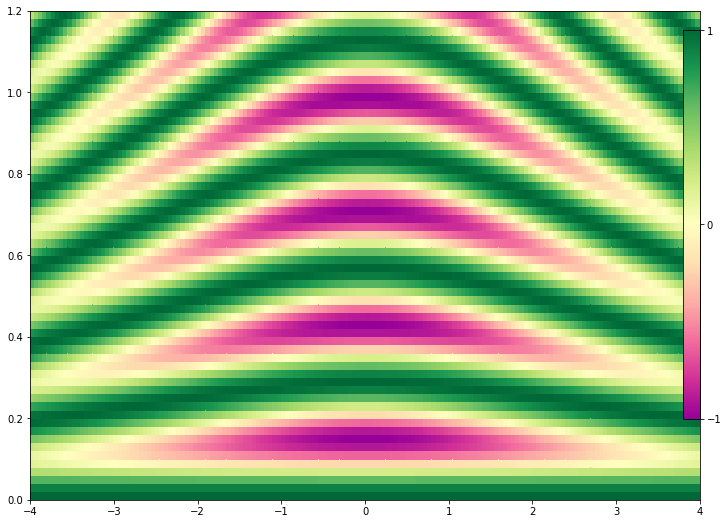

In [10]:
fig = plt.figure(figsize=(12,9))
setC = [0.88, 0.25, 0.02, 0.6]
axGrids = ck.Plotting.Functions.grid(1, 1, fig=fig)

ck.Plotting.SimplePlots.colorPlot(cavFreqSweep.sweepList, [x*qSim.stepSize for x in range(qSim.steps+1)], parityDigit,ax=axGrids[0], gif=fig, setC=setC)

In [ ]:
JCSys.reset()
JCSys.createSysCoupling([qub,cav],[QuantumToolbox.operators.sigmax, QuantumToolbox.operators.create], g)
JCSys.createSysCoupling([cav, qub],[QuantumToolbox.operators.destroy, QuantumToolbox.operators.sigmax], g)
JCSys.couplingName = 'Rabi'

print(JCSys.couplingName)

In [ ]:
print('simulating')
statesDigit = qSim.run(p, cav, cavFreqSweep.sweepList)
parityDigit = p.map(partial(expectationKetList, cavParity),statesDigit)
ck.Plotting.SimplePlots.colorPlot(cavFreqSweep.sweepList, qSim.times, parityDigit, irregular=irreg)
print(JCSys._QuantumSystem__kept)

In [ ]:
JCSys.reset(to='JC')
#JCSys.addCoupling([qub,cav],[qtbox.operators.destroy, qtbox.operators.create], g)
#JCSys.addCoupling([cav, qub],[qtbox.operators.destroy, qtbox.operators.create], g)
JCSys.sigmaX = QuantumToolbox.operators.sigmax
JCSys.Unitaries = digitalRabi

In [ ]:
print('simulating')
'''for i in range(len(cavFreqSweep.sweepList)):
    qSim.evolveTimeIndep(cav, cavFreqSweep.sweepList[i])'''
statesDigit = qSim.run(p, cav, cavFreqSweep.sweepList)
parityDigit = p.map(partial(expectationKetList, cavParity),statesDigit)
ck.Plotting.SimplePlots.colorPlot(cavFreqSweep.sweepList, qSim.times, parityDigit, irregular=irreg)
print(JCSys._QuantumSystem__kept)

In [ ]:
JCSys.reset(to='Rabi')
print('simulating')
statesDigit = qSim.run(p, cav, cavFreqSweep.sweepList)
parityDigit = p.map(partial(expectationKetList, cavParity),statesDigit)
ck.Plotting.SimplePlots.colorPlot(cavFreqSweep.sweepList, qSim.times, parityDigit, irregular=irreg)
print(JCSys._QuantumSystem__kept)

In [ ]:
JCSys.reset(to='JC')
JCcoupling.couplingStrength = 1
print('simulating')
statesDigit = qSim.run(p, cav, cavFreqSweep.sweepList)
parityDigit = p.map(partial(expectationKetList, cavParity),statesDigit)
ck.Plotting.SimplePlots.colorPlot(cavFreqSweep.sweepList, qSim.times, parityDigit, irregular=irreg)
print(JCSys._QuantumSystem__kept)

In [ ]:
JCSys.reset(to=2)
print(JCSys.couplingName)
JCcoupling.couplingStrength = 1.79
print('simulating')
statesDigit = qSim.run(p, cav, cavFreqSweep.sweepList)
parityDigit = p.map(partial(expectationKetList, cavParity),statesDigit)
ck.Plotting.SimplePlots.colorPlot(cavFreqSweep.sweepList, qSim.times, parityDigit, irregular=irreg)
print(JCSys._QuantumSystem__kept)